In [41]:
import sys
sys.path.append('/pl/active/banich/studies/Relevantstudies/abcd/data/clustering/analysis/')
sys.path.append('/pl/active/banich/studies/Relevantstudies/abcd/env/lib/python3.7/site-packages')

from functions import *
import shap
import xgboost
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from matplotlib import colors as plt_colors
import pandas as pd
from sklearn.metrics import pairwise_distances
from igraph import *

In [42]:
matched_subid = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/subj/matched_subid.csv')
matched_subid.columns = ['sub', 'SubID']

In [43]:
import glob
import pandas as pd
import re

# Define the pattern to match files
pattern = '/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/subj/sub*_sm_vector/sub*_sm_vector_*_all_ops.csv'

# Use glob to find all files that match the pattern
file_list = sorted(glob.glob(pattern))

# Initialize an empty list to store DataFrames
dataframes = []

for file in file_list:
    # Extract subject ID from the file path
    subject_id = re.search(r'sub(\d+)_', file).group(1)
    
    # Extract the part of the filename before '_all_ops'
    grad = re.search(r'_(g\d+)_all_ops', file).group(1)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file)
    
    # Add the subject ID as a new column
    df['SubID'] = subject_id
    
    # Add the 'grad' as a new column
    df['grad'] = grad
    
    # Append the DataFrame to the list
    dataframes.append(df)

# Combine all DataFrames into one, if necessary
combined_df = pd.concat(dataframes, ignore_index=True)

# Now 'combined_df' contains all data with a 'SubID' and 'grad' column indicating the subject ID and the gradient respectively.
# Adjusting the DataFrame by dropping and reordering columns as required
combined_df = combined_df.drop(['Unnamed: 0', 'sub'], axis=1, errors='ignore')  # errors='ignore' handles cases where these columns might not exist
combined_df = combined_df[['index', 'SubID', 'maintain', 'replace', 'suppress', 'clear', 'grad']]

# combined_df now includes the 'grad' column with the part of the filename you were interested in.

combined_df_g1 = combined_df.query('grad == "g1"').drop('grad', axis=1).reset_index(drop=True)
combined_df_g1.columns = ['index', 'SubID', 'maintain_g1', 'replace_g1', 'suppress_g1', 'clear_g1']

combined_df_g2 = combined_df.query('grad == "g2"').drop('grad', axis=1).reset_index(drop=True)
combined_df_g2.columns = ['index', 'SubID', 'maintain_g2', 'replace_g2', 'suppress_g2', 'clear_g2']

combined_df_g3 = combined_df.query('grad == "g3"').drop('grad', axis=1).reset_index(drop=True)
combined_df_g3.columns = ['index', 'SubID', 'maintain_g3', 'replace_g3', 'suppress_g3', 'clear_g3']

combined_all = pd.concat([combined_df_g1, 
                          combined_df_g2.drop(['index', 'SubID'], axis=1), 
                          combined_df_g3.drop(['index', 'SubID'], axis=1)], axis=1)

combined_all = combined_all[['index', 'SubID', 'maintain_g1', 'maintain_g2', 'maintain_g3', 'replace_g1', 'replace_g2', 'replace_g3', 
              'suppress_g1', 'suppress_g2', 'suppress_g3', 'clear_g1', 'clear_g2', 'clear_g3']]

wm_networks = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/rest/rest_gradients/wm_networks.csv')
wm_networks = wm_networks.reset_index()

combined_all = pd.merge(wm_networks, combined_all, on='index').sort_values(['SubID', 'index'])

In [44]:
combined_all

,index,Subtype,SubID,maintain_g1,maintain_g2,maintain_g3,replace_g1,replace_g2,replace_g3,suppress_g1,suppress_g2,suppress_g3,clear_g1,clear_g2,clear_g3
0,0,1,001,0.096287,-0.013495,-0.003869,0.080219,-0.009836,-0.004120,0.049993,-0.007989,0.004917,0.065139,-0.002771,0.000150
54,1,1,001,-0.001073,-0.021358,-0.016606,-0.013028,-0.021415,-0.007935,-0.022651,-0.040969,-0.012832,0.001080,0.007121,-0.012178
108,2,1,001,-0.030895,-0.056522,-0.007680,-0.033789,-0.055268,-0.015599,-0.040519,-0.084220,-0.037254,-0.062568,-0.126665,-0.019183
162,3,1,001,0.132592,-0.013745,-0.004615,0.132601,-0.018359,-0.013180,0.127104,-0.017073,-0.006248,0.132353,-0.015060,-0.005994
216,4,1,001,0.141616,-0.014493,-0.009292,0.145434,-0.020682,-0.018584,0.143578,-0.018360,-0.019319,0.146000,-0.018189,-0.009016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19223,355,4,055,-0.031754,-0.001941,0.026918,-0.028308,-0.003776,0.030041,-0.024611,0.001892,0.032449,-0.021529,-0.001609,0.026138
19277,356,4,055,-0.028700,0.020819,-0.049656,-0.027097,0.042825,-0.045951,-0.026194,0.023621,-0.044399,-0.025800,0.041611,-0.049637
19331,357,4,055,-0.037917,-0.002758,0.032737,-0.030563,-0.003876,0.026209,-0.022609,0.002976,0.021044,-0.033234,0.008046,0.017336
19385,358,3,055,-0.012324,0.009270,-0.005502,-0.012861,0.009657,0.000160,-0.015044,0.021937,-0.009326,-0.010535,0.008429,-0.011213


In [4]:
group_main = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/grp/main_grads.csv').iloc[:, 1:]
group_replace = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/grp/replace_grads.csv').iloc[:, 1:]
group_suppress = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/grp/suppress_grads.csv').iloc[:, 1:]
group_clear = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/grp/clear_grads.csv').iloc[:, 1:]

group_main.columns = ['maintain_g1', 'maintain_g2', 'maintain_g3']
group_replace.columns = ['replace_g1', 'replace_g2', 'replace_g3']
group_suppress.columns = ['suppress_g1', 'suppress_g2', 'suppress_g3']
group_clear.columns = ['clear_g1', 'clear_g2', 'clear_g3']

group_grads = pd.concat([group_main, group_replace, group_suppress, group_clear], axis=1).reset_index()
group_grads = pd.merge(wm_networks, group_grads, on='index')#.sort_values(['SubID', 'index'])

In [5]:
#group = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/leiden/group_sm_vector_spearman/Output/Results/group_sm_vector_spearman_Full_Subtypes.csv')

#gmat_main = group.iloc[:, 5:].iloc[:, 0:10332]
#gmat_replace = group.iloc[:, 5:].iloc[:, 10332:int(10332*2)]
#gmat_suppress = group.iloc[:, 5:].iloc[:, int(10332*2):int(10332*3)]
#gmat_clear = group.iloc[:, 5:].iloc[:, int(10332*3):int(10332*4)]

#group_subs = group[['Unnamed: 0', 'Subtype']].rename({'Unnamed: 0':'index'}, axis=1)

In [6]:
def get_modularity(data, op):
    
    from scipy.stats import spearmanr, pearsonr
    from scipy import stats
    from scipy.spatial import distance
    import math
    import networkx as nx
    import numpy as np
        #=======================================================================================================#
    def hadamard(nearest):
        """
        This function converts a directed adjacency matrix to a matrix of Hadamard distances
        based on the overlap of neighbors. The implementation is efficiently based
        on matrix multiplications.
        A an N-by-N adjacency matrix holding TRUE or 1 values for edges an N-by-N matrix with
        the Hadamard coefficient of neighbor overlap.
        """

        common = nearest.T @ nearest
        ranks = np.outer(np.diag(common), np.ones(nearest.shape[0]))
        neighborUnion = ranks + ranks.T - common
        G = common / neighborUnion
        np.fill_diagonal(G, 0)

        return G

    #=======================================================================================================#
    def topMax(x, N):
        """
        find Nth largest number in an array
        """

        L = len(x)
        assert N < L, 'Number of neighbors cannot be larger than length of data'

        while L != 1:
            initial_guess = x[0]
            top_list = x[x > initial_guess]
            bottom_list = x[x < initial_guess]

            topL = len(top_list)
            bottomL = len(bottom_list)

            if (topL < N) and (L - bottomL >= N):
                x = initial_guess
                break

            if topL >= N:
                x = top_list
            else:
                x = bottom_list
                N = N - L + bottomL
            L = len(x)

        return x

    #=======================================================================================================#
    def bottomMin(x, N):
        """
        find Nth smallest number in an array
        """

        return np.round(topMax(x, len(x) - N + 1))

    #=======================================================================================================#
    def find_neighbors(D, k):
        """
        Tranform distance matrix to binary k-nearest neighbors graph
        """

        nearest = np.zeros(D.shape)
        for i in range(nearest.shape[1]):
            nearest[:,i] = np.round(D[:,i]) <= bottomMin(np.round(D[:,i]), k)


        return nearest

    df = data.filter(regex=op)
    # Assuming your DataFrame is named df and has columns 'maintain_g1', 'maintain_g2', 'maintain_g3'
    data_columns = df.columns
    
    mahal = '''
    ########
        # Calculate the inverse of the covariance matrix
    cov_matrix = np.cov(df[data_columns].values, rowvar=False)
    inv_cov_matrix = inv(cov_matrix)

    # Function to calculate the Mahalanobis distance matrix
    def mahalanobis_matrix(data, inv_cov_matrix):
        n = data.shape[0]
        mahal_matrix = np.zeros((n, n))

        for i in range(n):
            for j in range(i, n):
                diff = data[i] - data[j]
                dist = np.dot(np.dot(diff, inv_cov_matrix), diff.T)
                mahal_matrix[i, j] = np.sqrt(dist)
                mahal_matrix[j, i] = mahal_matrix[i, j]  # Since the matrix is symmetric

        return mahal_matrix

    # Calculate the Mahalanobis distance matrix
    data_values = df[data_columns].values
    mahal_matrix = mahalanobis_matrix(data_values, inv_cov_matrix)
    # If you want to put this matrix into a DataFrame (optional):
    mahal_df = pd.DataFrame(mahal_matrix, index=df.index, columns=df.index)
    ########
    '''

    X = np.array(df)
    X_Z =  np.array(df)
    D, rho = spearmanr(np.array(X_Z), axis=1)
    D = np.round((X_Z.shape[1]**3 - X_Z.shape[1]) * (1 - D) / 6).astype(np.int)
    #D = rho
    from sklearn.metrics import pairwise_distances
    D = pairwise_distances(np.array(df), metric='correlation')

    #D = np.array(mahal_df)
    k = np.ceil(math.sqrt(D.shape[0]))
   #k=30
    nearest = find_neighbors(D, k + 1)
    adjacency_matrix = hadamard(nearest)  
    adjacency_matrix = D
    
    def calculate_modularity_and_contributions(adjacency_matrix, communities):
        
        m = adjacency_matrix.sum() / 2.0  # Total weight of edges in the graph, for weighted networks
        total_modularity = 0.0
        community_contributions = []

        for community in communities:
            L_c = 0.0  # Total weight of all the edges within a community, for weighted networks
            D_c = 0.0  # Total degree (sum of edge weights) of the nodes in the community
            for i in community:
                for j in community:
                    L_c += adjacency_matrix[i, j]
                D_c += adjacency_matrix[i].sum()

            # Modularity contribution from this community
            contribution = (L_c / (2 * m)) - (D_c / (2 * m)) ** 2
            community_contributions.append(contribution)
            total_modularity += contribution

        return total_modularity, community_contributions

    communities = np.array(group_grads.Subtype)

    import numpy as np

    # Assuming `communities` is a NumPy array where each element is the community label of a node
    unique_communities = np.unique(communities)
    community_lists = [np.where(communities == community)[0].tolist() for community in unique_communities]

    # Now you can use `community_lists` with the function
    total_modularity, contributions = calculate_modularity_and_contributions(adjacency_matrix, community_lists)
    #print("Total Modularity Score:", total_modularity)
    #print("Community Contributions to Modularity:", contributions)
    
    return total_modularity, contributions

In [7]:
def get_modularity(data, op):
    
    from scipy.stats import spearmanr, pearsonr
    from scipy import stats
    from scipy.spatial import distance
    import math
    import networkx as nx
    import numpy as np
    
        #=======================================================================================================#
    def hadamard(nearest):
        """
        This function converts a directed adjacency matrix to a matrix of Hadamard distances
        based on the overlap of neighbors. The implementation is efficiently based
        on matrix multiplications.
        A an N-by-N adjacency matrix holding TRUE or 1 values for edges an N-by-N matrix with
        the Hadamard coefficient of neighbor overlap.
        """

        common = nearest.T @ nearest
        ranks = np.outer(np.diag(common), np.ones(nearest.shape[0]))
        neighborUnion = ranks + ranks.T - common
        G = common / neighborUnion
        np.fill_diagonal(G, 0)

        return G

    #=======================================================================================================#
    def topMax(x, N):
        """
        find Nth largest number in an array
        """

        L = len(x)
        assert N < L, 'Number of neighbors cannot be larger than length of data'

        while L != 1:
            initial_guess = x[0]
            top_list = x[x > initial_guess]
            bottom_list = x[x < initial_guess]

            topL = len(top_list)
            bottomL = len(bottom_list)

            if (topL < N) and (L - bottomL >= N):
                x = initial_guess
                break

            if topL >= N:
                x = top_list
            else:
                x = bottom_list
                N = N - L + bottomL
            L = len(x)

        return x

    #=======================================================================================================#
    def bottomMin(x, N):
        """
        find Nth smallest number in an array
        """

        return np.round(topMax(x, len(x) - N + 1))

    #=======================================================================================================#
    def find_neighbors(D, k):
        """
        Tranform distance matrix to binary k-nearest neighbors graph
        """

        nearest = np.zeros(D.shape)
        for i in range(nearest.shape[1]):
            nearest[:,i] = np.round(D[:,i]) <= bottomMin(np.round(D[:,i]), k)


        return nearest

    df = data.filter(regex=op)
    # Assuming your DataFrame is named df and has columns 'maintain_g1', 'maintain_g2', 'maintain_g3'
    data_columns = df.columns
    
   #mahal = '''
    ########
        # Calculate the inverse of the covariance matrix
    from scipy.linalg import inv  # Ensure this import statement is included

    cov_matrix = np.cov(df[data_columns].values, rowvar=False)
    inv_cov_matrix = inv(cov_matrix)

    # Function to calculate the Mahalanobis distance matrix
    def mahalanobis_matrix(data, inv_cov_matrix):
        n = data.shape[0]
        mahal_matrix = np.zeros((n, n))

        for i in range(n):
            for j in range(i, n):
                diff = data[i] - data[j]
                dist = np.dot(np.dot(diff, inv_cov_matrix), diff.T)
                mahal_matrix[i, j] = np.sqrt(dist)
                mahal_matrix[j, i] = mahal_matrix[i, j]  # Since the matrix is symmetric

        return mahal_matrix

    # Calculate the Mahalanobis distance matrix
    data_values = df[data_columns].values
    mahal_matrix = mahalanobis_matrix(data_values, inv_cov_matrix)
    # If you want to put this matrix into a DataFrame (optional):
    mahal_df = pd.DataFrame(mahal_matrix, index=df.index, columns=df.index)
    ########
    #'''
        
    #X_Z =  np.array(df)
    #D, rho = spearmanr(np.array(X_Z), axis=1)
    #D = np.round((X_Z.shape[1]**3 - X_Z.shape[1]) * (1 - D) / 6).astype(np.int)
    #D = rho
    D = np.array(mahal_df)
    #k = np.ceil(math.sqrt(D.shape[0]))

    #nearest = find_neighbors(D, k + 1)
    #G = hadamard(nearest)  
    adjacency_matrix = np.array(mahal_df)
    gframe = pd.DataFrame(D)
    #gframe = reduce_memory_usage(gframe)
    graph = Graph.Weighted_Adjacency(gframe.values.tolist(), mode=ADJ_UNDIRECTED, attr="weight")
    G = graph.to_networkx()
    
    def calculate_modularity_and_contributions(adjacency_matrix, communities):
        
        m = adjacency_matrix.sum() / 2.0  # Total weight of edges in the graph, for weighted networks
        total_modularity = 0.0
        community_contributions = []

        for community in communities:
            L_c = 0.0  # Total weight of all the edges within a community, for weighted networks
            D_c = 0.0  # Total degree (sum of edge weights) of the nodes in the community
            for i in community:
                for j in community:
                    L_c += adjacency_matrix[i, j]
                D_c += adjacency_matrix[i].sum()

            # Modularity contribution from this community
            contribution = (L_c / (2 * m)) - (D_c / (2 * m)) ** 2
            community_contributions.append(abs(contribution))
            total_modularity += abs(contribution)

        return total_modularity, community_contributions

    communities = np.array(group_grads.Subtype)

    import numpy as np

    # Assuming `communities` is a NumPy array where each element is the community label of a node
    unique_communities = np.unique(communities)
    community_lists = [np.where(communities == community)[0].tolist() for community in unique_communities]

    # Now you can use `community_lists` with the function
    total_modularity, contributions = calculate_modularity_and_contributions(adjacency_matrix, community_lists)

    return total_modularity, contributions
    
def get_mods(data, sub):

    group_mod = []

    for i in ['maintain', 'replace', 'suppress', 'clear']:
        group_mod.append(get_modularity(data, i))

    def clean_mods(group_mod):

        op_mods=[]
        for i in range(len(group_mod)):
            op_mods.append(group_mod[i][0])

        op_mods=pd.DataFrame([op_mods]).rename({0:'main_mod',
                                                1:'replace_mod',
                                                2:'suppress_mod',
                                                3:'clear_mod',
                                               }, axis=1)

        op_net_mods=[]
        for i in range(len(group_mod)):
            op_net_mods.append(group_mod[i][1])

        main_mods=pd.DataFrame([op_net_mods[0]])
        main_mods.columns = ['vn_main_mod', 'smn_main_mod', 'fpcn_main_mod', 'dmn_main_mod']

        replace_mods=pd.DataFrame([op_net_mods[1]])
        replace_mods.columns = ['vn_replace_mod', 'smn_replace_mod', 'fpcn_replace_mod', 'dmn_replace_mod']

        suppress_mods=pd.DataFrame([op_net_mods[2]])
        suppress_mods.columns = ['vn_suppress_mod', 'smn_suppress_mod', 'fpcn_suppress_mod', 'dmn_suppress_mod']

        clear_mods=pd.DataFrame([op_net_mods[3]])
        clear_mods.columns = ['vn_clear_mod', 'smn_clear_mod', 'fpcn_clear_mod', 'dmn_clear_mod']

        all_mods = pd.concat([op_mods, main_mods, replace_mods, suppress_mods, clear_mods], axis=1)

        return all_mods

    all_mods = clean_mods(group_mod)
    all_mods_cols = ['SubID'] + all_mods.columns.to_list()
    all_mods = all_mods.assign(SubID = sub)[all_mods_cols]

    return all_mods
    
get_mods(group_grads, 'group')

,SubID,main_mod,replace_mod,suppress_mod,clear_mod,vn_main_mod,smn_main_mod,fpcn_main_mod,dmn_main_mod,vn_replace_mod,...,fpcn_replace_mod,dmn_replace_mod,vn_suppress_mod,smn_suppress_mod,fpcn_suppress_mod,dmn_suppress_mod,vn_clear_mod,smn_clear_mod,fpcn_clear_mod,dmn_clear_mod
0,group,0.134613,0.136742,0.136028,0.142212,0.036646,0.024603,0.035075,0.03829,0.036724,...,0.035409,0.039257,0.036199,0.025969,0.034545,0.039314,0.039165,0.026124,0.037396,0.039527


In [8]:
sub_mods =[]
for i in combined_all.SubID.unique():
    #print(i)
    sub_mod_grads = combined_all.query('SubID == @i')
    sub_mods.append(get_mods(sub_mod_grads, i))

sub_mods_df = pd.concat(sub_mods).reset_index(drop=True) 
sub_mods_df['SubID'] = sub_mods_df.SubID.astype(int)

In [9]:
sub_mods_df = (pd.merge(matched_subid, sub_mods_df, on='SubID')
               .drop('SubID', axis=1).rename({'sub':'SubID'}, axis=1))

In [10]:
sub_net_mods = sub_mods_df.drop(['main_mod', 'replace_mod', 'suppress_mod', 'clear_mod'], axis=1)

In [11]:
sub_net_disp = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/dispersion_data/derosa_task_network_dispersion.csv')
#sub_net_disp.iloc[:, 1:] = sub_net_disp.iloc[:, 1:] * -1

In [12]:
merged = pd.merge(sub_net_mods, sub_net_disp, on='SubID')

In [13]:
#sns.heatmap(merged.filter(regex='vn').corr(), cmap='bwr', center=0, annot=True)

In [14]:
def pls(data, target, networks, color, save=None):


    regex_string = '|'.join(networks)

    import seaborn as sns
    from sklearn.cross_decomposition import PLSRegression
    from scipy.stats import t
    import numpy as np
    import matplotlib.pyplot as plt
    import statsmodels.api as sm

    from sklearn.preprocessing import MinMaxScaler
    from sklearn.preprocessing import RobustScaler
    from sklearn.preprocessing import StandardScaler
    
    from sklearn.model_selection import cross_val_predict
    from sklearn.metrics import mean_squared_error
    from sklearn.model_selection import LeaveOneOut
    # Create an instance of LeaveOneOut
    loo = LeaveOneOut()

    
    scaler=MinMaxScaler()
    
    X_data = data
    # Extract the feature matrix X and target variable y
    X = (X_data 
             .filter(regex=regex_string)
             #.filter(like='dispersion_md')
             #.filter(regex='^(?!.*(main|suppress|replace)).*$')
             #.filter(regex='^(?!.*(maintain_smn)).*$') 
            )

    # fit and transform the entire dataframe
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    y = X_data[target]
    y = pd.DataFrame(scaler.fit_transform(y), columns=y.columns)

    # Set the number of permutations and bootstrap repetitions
    n_permutations = 10000
    n_bootstrap = 10000

    pls = PLSRegression(n_components=1)
        
    # Perform leave-one-out cross-validation to determine the optimal number of components
    #mse_values = []
    #for n_components in range(1, len(X.columns)+1):
    #    pls.n_components = n_components
    #    y_pred = cross_val_predict(pls, X, y, cv=loo)
    #    mse = mean_squared_error(y, y_pred)
    #    mse_values.append(mse)

    #pls = PLSRegression(n_components=1)
    #optimal_n_components = np.argmin(mse_values) + 1
    #print('Optimal number of components:', optimal_n_components)

    # Fit the PLSRegression model to the feature matrix X and target variable y using the optimal number of components
    pls.n_components = 1 #optimal_n_components
    pls.fit(X, y)

    # Compute the singular value of the fitted model
    x_score = pls.x_scores_
    y_score = pls.y_scores_
    singular_value = np.dot(x_score.T, y_score)
    print('Starting Permutations')
    # Generate permuted data matrices by randomly reordering the rows of the original data matrix X
    permuted_singular_values = []
    for i in range(n_permutations):
        permuted_X = X.sample(frac=1, replace=False)
        pls.fit(permuted_X, y)
        x_score = pls.x_scores_
        y_score = pls.y_scores_
        permuted_singular_value = np.dot(x_score.T, y_score)
        permuted_singular_values.append(permuted_singular_value)

    # Compute the p-value of the singular value by comparing it to the null distribution of singular values
    p_value = (np.sum(permuted_singular_values >= singular_value) + 1) / (n_permutations + 1)
    
    import seaborn as sns
    from sklearn.cross_decomposition import PLSRegression
    from scipy.stats import t
    import numpy as np
    import matplotlib.pyplot as plt
    import statsmodels.api as sm
    import matplotlib

       # Prepare data for the histogram
    singular_list = [i[0][0] for i in permuted_singular_values]
    singulars = pd.DataFrame(singular_list, columns=['Singulars'])
    singular_val = singular_value[0][0]

    # Begin plotting
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))  # Set up a figure with two subplots
    
    # Scatter plot on the left
    sns.set_theme(style="white")

    sns.regplot(x=x_score.flatten(), y=y_score.flatten(), 
                ax=axs[0], color=color, scatter_kws={'alpha':0.6}, truncate=False)
    axs[0].set_xlabel('Network Dispersion (Latent Variable)', fontsize=14)
    axs[0].set_ylabel('Behavior (Latent Variable)', fontsize=14)
    axs[0].set_title('Network Dispersion Predicting Behavior', fontsize=14, fontweight='bold')
    
       # Displaying 'permuted P = ' with manual positioning for readability
    axs[0].text(.06, 1, 'permuted ', transform=axs[0].transAxes, fontsize=13, verticalalignment='top', color='black')
    axs[0].text(.22, 1, 'P', transform=axs[0].transAxes, fontsize=13, verticalalignment='top', color='black', fontstyle='italic')
    axs[0].text(.24, 1, ' = {:.3f}'.format(p_value), transform=axs[0].transAxes, fontsize=13, verticalalignment='top', color='black')
    
    sns.despine(ax=axs[0])

    # Histogram on the right
    sns.histplot(singulars, kde=False, ax=axs[1])
    axs[1].axvline(x=singular_val, color='r', linestyle='--', label='Singular Value')
    axs[1].legend()
    axs[1].set_title("Singular Value vs. Null Distribution", fontsize=14, fontweight='bold')
    axs[1].set_xlabel('Permuted Singular Values (Null)', fontsize=14)
    sns.despine(ax=axs[1])
    plt.tight_layout()  # Adjust layout to not overlap
    
    if save is not None:
        save_path = f"/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/analysis/pls_plots/{save}.png"
        plt.savefig(save_path, dpi=700)
        
    plt.tight_layout()  # Adjust layout to not overlap
    plt.show()
    

    return p_value, x_score, y_score, permuted_singular_values, singular_value


In [15]:
z_data = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/analysis/ClearMem_Z_Average.csv')
z_data = z_data[['SubID', 'z_ave', 'PSWQ_total', 'WBSI_total', 'RRS_total', 'RRS_depression', 'RRS_brooding', 'RRS_reflection']]
z_data = z_data.dropna()

In [16]:
merged_z = pd.merge(z_data, merged.filter(regex='Sub|mod'), on='SubID')

Starting Permutations


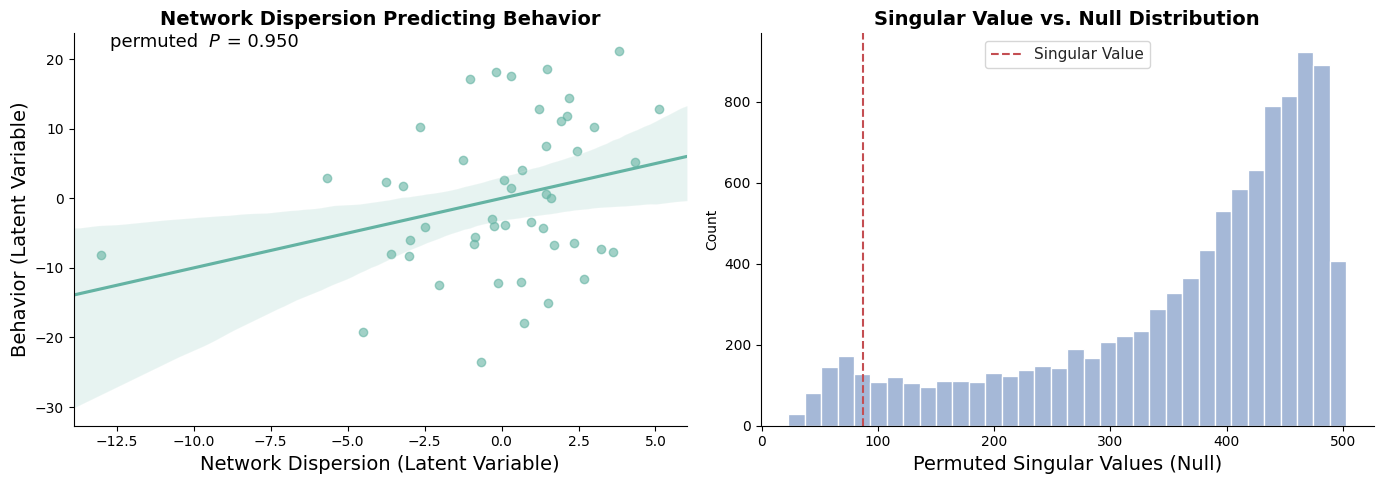

Starting Permutations


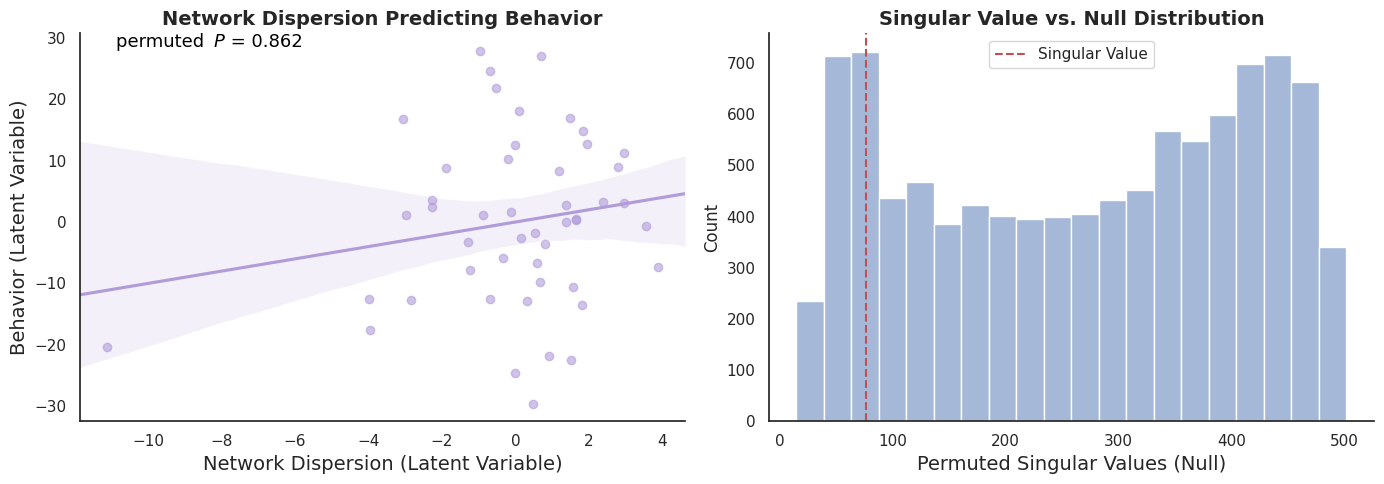

In [17]:
targets = [['RRS_total', 'PSWQ_total', 'WBSI_total'], ['z_ave']]
colors = ['#64b3a3', '#b19cd9']

networks = ['vn', 'smn', 'fpcn', 'dmn']
names = ['rrs_pws_wbsi_netmod', 'z_ave_netmod']

for i,j,k in zip(targets, colors, names):
    p_value, x_score, y_score, permuted_singular_values, singular_value = pls(merged_z, i, networks, j, k)


In [18]:
sub_op_mods = sub_mods_df[['SubID', 'main_mod', 'replace_mod', 'suppress_mod', 'clear_mod']]

sub_op_mods_z = pd.merge(z_data, sub_op_mods, on='SubID')

In [36]:
sub_mods_df.to_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/dispersion_data/derosa_task_network_modularity.csv')

Starting Permutations


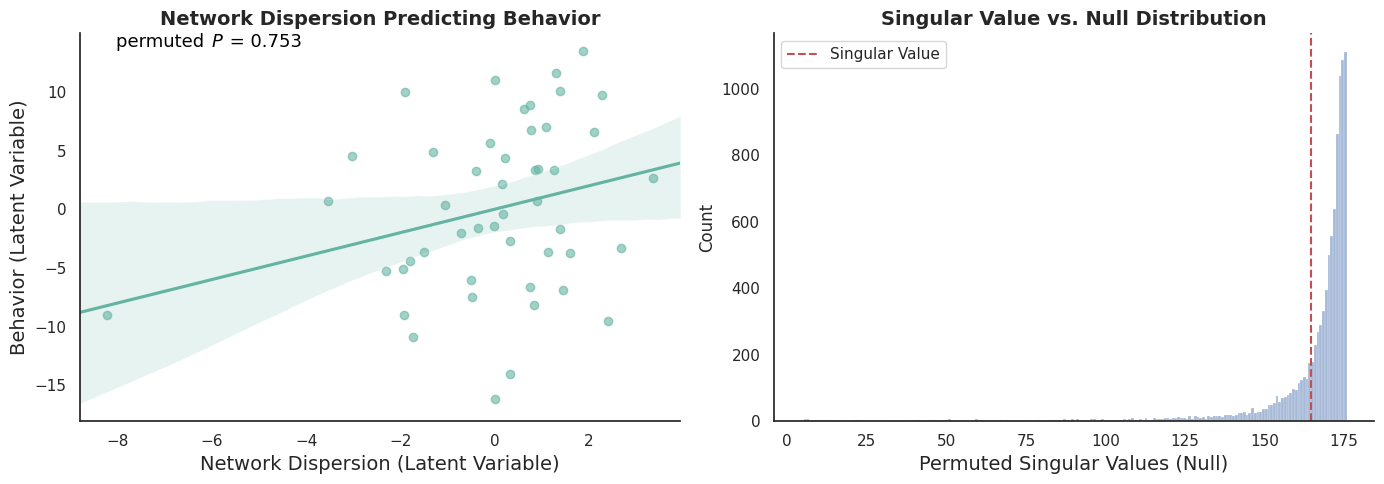

Starting Permutations


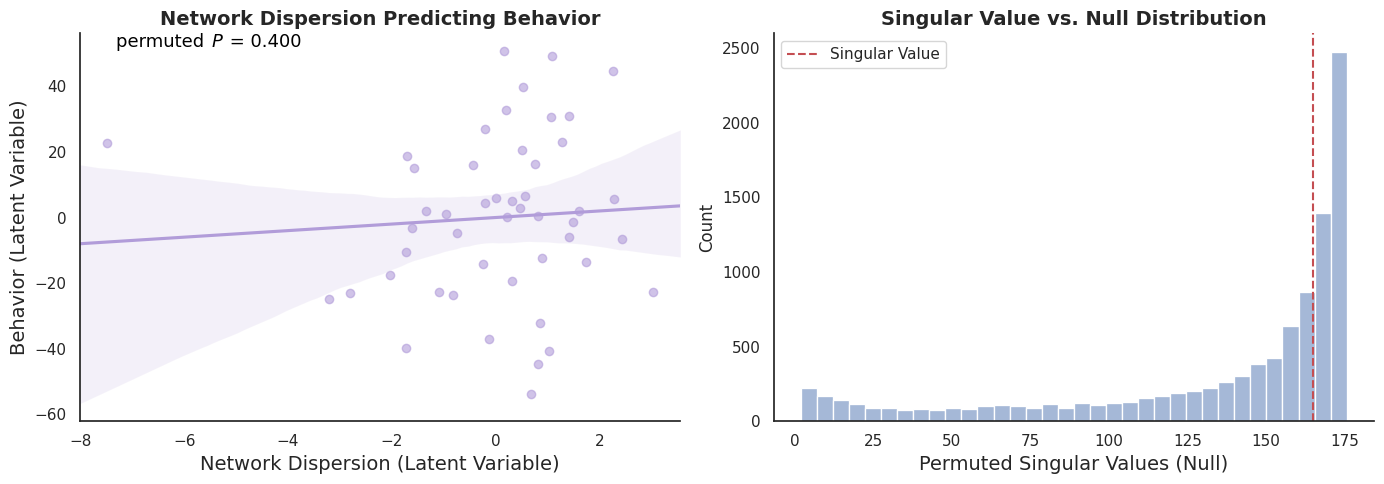

In [19]:
targets = [['RRS_total', 'PSWQ_total', 'WBSI_total'], ['z_ave']]
colors = ['#64b3a3', '#b19cd9']

networks = ['main', 'suppress', 'replace', 'clear']
names = ['rrs_pws_wbsi_mod', 'z_ave_mod']

for i,j,k in zip(targets, colors, names):
    p_value, x_score, y_score, permuted_singular_values, singular_value = pls(sub_op_mods_z, i, networks, j, k)

In [20]:
from scipy.stats import spearmanr, pearsonr
from scipy import stats
from scipy.spatial import distance
import math
import networkx as nx
import numpy as np
from igraph import *

    #=======================================================================================================#
def hadamard(nearest):
    """
    This function converts a directed adjacency matrix to a matrix of Hadamard distances
    based on the overlap of neighbors. The implementation is efficiently based
    on matrix multiplications.
    A an N-by-N adjacency matrix holding TRUE or 1 values for edges an N-by-N matrix with
    the Hadamard coefficient of neighbor overlap.
    """

    common = nearest.T @ nearest
    ranks = np.outer(np.diag(common), np.ones(nearest.shape[0]))
    neighborUnion = ranks + ranks.T - common
    G = common / neighborUnion
    np.fill_diagonal(G, 0)

    return G

#=======================================================================================================#
def topMax(x, N):
    """
    find Nth largest number in an array
    """

    L = len(x)
    assert N < L, 'Number of neighbors cannot be larger than length of data'

    while L != 1:
        initial_guess = x[0]
        top_list = x[x > initial_guess]
        bottom_list = x[x < initial_guess]

        topL = len(top_list)
        bottomL = len(bottom_list)

        if (topL < N) and (L - bottomL >= N):
            x = initial_guess
            break

        if topL >= N:
            x = top_list
        else:
            x = bottom_list
            N = N - L + bottomL
        L = len(x)

    return x

#=======================================================================================================#
def bottomMin(x, N):
    """
    find Nth smallest number in an array
    """

    return np.round(topMax(x, len(x) - N + 1))

#=======================================================================================================#
def find_neighbors(D, k):
    """
    Tranform distance matrix to binary k-nearest neighbors graph
    """

    nearest = np.zeros(D.shape)
    for i in range(nearest.shape[1]):
        nearest[:,i] = np.round(D[:,i]) <= bottomMin(np.round(D[:,i]), k)


    return nearest

import numpy as np
import pandas as pd
import networkx as nx
import math
from scipy.stats import spearmanr

def compute_network_metrics(data, op, net, sub):

    df = data.filter(regex=op)
    # Assuming your DataFrame is named df and has columns 'maintain_g1', 'maintain_g2', 'maintain_g3'
    data_columns = df.columns
    
    
    #mahal = '''
    ########
        # Calculate the inverse of the covariance matrix
    from scipy.linalg import inv  # Ensure this import statement is included

    cov_matrix = np.cov(df[data_columns].values, rowvar=False)
    inv_cov_matrix = inv(cov_matrix)

    # Function to calculate the Mahalanobis distance matrix
    def mahalanobis_matrix(data, inv_cov_matrix):
        n = data.shape[0]
        mahal_matrix = np.zeros((n, n))

        for i in range(n):
            for j in range(i, n):
                diff = data[i] - data[j]
                dist = np.dot(np.dot(diff, inv_cov_matrix), diff.T)
                mahal_matrix[i, j] = np.sqrt(dist)
                mahal_matrix[j, i] = mahal_matrix[i, j]  # Since the matrix is symmetric

        return mahal_matrix

    # Calculate the Mahalanobis distance matrix
    data_values = df[data_columns].values
    mahal_matrix = mahalanobis_matrix(data_values, inv_cov_matrix)
    # If you want to put this matrix into a DataFrame (optional):
    mahal_df = pd.DataFrame(mahal_matrix, index=df.index, columns=df.index)
    ########
    #'''
        
    #X_Z =  np.array(df)
    #D, rho = spearmanr(np.array(X_Z), axis=1)
    #D = np.round((X_Z.shape[1]**3 - X_Z.shape[1]) * (1 - D) / 6).astype(np.int)
    #D = rho
    G = np.array(mahal_df)
    #k = np.ceil(math.sqrt(D.shape[0]))
    
    #nearest = find_neighbors(D, k + 1)
    #G = hadamard(nearest)  

    gframe = pd.DataFrame(G)
    #gframe = reduce_memory_usage(gframe)
    graph = Graph.Weighted_Adjacency(gframe.values.tolist(), mode=ADJ_UNDIRECTED, attr="weight")
    G = graph.to_networkx()
 
    metrics = pd.DataFrame({
        #'efficiency': nx.global_efficiency(G),
        #'local_efficiency': nx.local_efficiency(G),
        #'degree_centrality': nx.degree_centrality(G),
        'eigenvector_centrality': nx.eigenvector_centrality(G, weight='weight', max_iter=500, tol=1e-06),
        #'closeness_centrality': nx.closeness_centrality(G, distance='weight'), 
        #'pagerank' : nx.pagerank(G),  
    })
    #print(metrics)
    metrics = pd.DataFrame(metrics.sum()).T
    
    metrics.columns = [f'{op}_{net}_{i}' for i in metrics.columns]
    
    cols = ['SubID'] + metrics.columns.to_list()
    
    metrics=metrics.assign(SubID = sub)
    metrics = metrics[cols]

    return metrics

compute_network_metrics(group_grads.query('Subtype == 1'), 'maintain', 'vn', 'group')

In [22]:
import numpy as np
import pandas as pd
import networkx as nx
import math
from scipy.stats import spearmanr

def compute_network_graphs(data, op, sub):

    df = data.filter(regex=op)
    # Assuming your DataFrame is named df and has columns 'maintain_g1', 'maintain_g2', 'maintain_g3'
    data_columns = df.columns
    
    
    #mahal = '''
    ########
        # Calculate the inverse of the covariance matrix
    from scipy.linalg import inv  # Ensure this import statement is included

    cov_matrix = np.cov(df[data_columns].values, rowvar=False)
    inv_cov_matrix = inv(cov_matrix)

    # Function to calculate the Mahalanobis distance matrix
    def mahalanobis_matrix(data, inv_cov_matrix):
        n = data.shape[0]
        mahal_matrix = np.zeros((n, n))

        for i in range(n):
            for j in range(i, n):
                diff = data[i] - data[j]
                dist = np.dot(np.dot(diff, inv_cov_matrix), diff.T)
                mahal_matrix[i, j] = np.sqrt(dist)
                mahal_matrix[j, i] = mahal_matrix[i, j]  # Since the matrix is symmetric

        return mahal_matrix

    # Calculate the Mahalanobis distance matrix
    data_values = df[data_columns].values
    mahal_matrix = mahalanobis_matrix(data_values, inv_cov_matrix)
    # If you want to put this matrix into a DataFrame (optional):
    mahal_df = pd.DataFrame(mahal_matrix, index=df.index, columns=df.index)
    ########
    #'''
        
    #X_Z =  np.array(df)
    #D, rho = spearmanr(np.array(X_Z), axis=1)
    #D = np.round((X_Z.shape[1]**3 - X_Z.shape[1]) * (1 - D) / 6).astype(np.int)
    #D = rho
    G = np.array(mahal_df)
    #k = np.ceil(math.sqrt(D.shape[0]))
    
    #nearest = find_neighbors(D, k + 1)
    #G = hadamard(nearest)  

    gframe = pd.DataFrame(G)
    #gframe = reduce_memory_usage(gframe)

    return gframe

def participation_coef(W, ci, degree='undirected'):
    '''
    Participation coefficient is a measure of diversity of intermodular
    connections of individual nodes.

    Parameters
    ----------
    W : NxN np.ndarray
        binary/weighted directed/undirected connection matrix
    ci : Nx1 np.ndarray
        community affiliation vector
    degree : str
        Flag to describe nature of graph 'undirected': For undirected graphs
                                         'in': Uses the in-degree
                                         'out': Uses the out-degree

    Returns
    -------
    P : Nx1 np.ndarray
        participation coefficient
    '''
    if degree == 'in':
        W = W.T

    _, ci = np.unique(ci, return_inverse=True)
    ci += 1

    n = len(W)  # number of vertices
    Ko = np.sum(W, axis=1)  # (out) degree
    Gc = np.dot((W != 0), np.diag(ci))  # neighbor community affiliation
    Kc2 = np.zeros((n,))  # community-specific neighbors

    for i in range(1, int(np.max(ci)) + 1):
        Kc2 = Kc2 + np.square(np.sum(W * (Gc == i), axis=1))

    P = np.ones((n,)) - Kc2 / np.square(Ko)
    # P=0 if for nodes with no (out) neighbors
    P[np.where(np.logical_not(Ko))] = 0

    return P

In [23]:
import numpy as np
import pandas as pd
import networkx as nx
import math
from scipy.stats import spearmanr

def compute_network_graphs(data, op, sub):

    df = data.filter(regex=op)
    # Assuming your DataFrame is named df and has columns 'maintain_g1', 'maintain_g2', 'maintain_g3'
    data_columns = df.columns
    
    
    #mahal = '''
    ########
        # Calculate the inverse of the covariance matrix
    from scipy.linalg import inv  # Ensure this import statement is included

    cov_matrix = np.cov(df[data_columns].values, rowvar=False)
    inv_cov_matrix = inv(cov_matrix)

    # Function to calculate the Mahalanobis distance matrix
    def mahalanobis_matrix(data, inv_cov_matrix):
        n = data.shape[0]
        mahal_matrix = np.zeros((n, n))

        for i in range(n):
            for j in range(i, n):
                diff = data[i] - data[j]
                dist = np.dot(np.dot(diff, inv_cov_matrix), diff.T)
                mahal_matrix[i, j] = np.sqrt(dist)
                mahal_matrix[j, i] = mahal_matrix[i, j]  # Since the matrix is symmetric

        return mahal_matrix

    # Calculate the Mahalanobis distance matrix
    data_values = df[data_columns].values
    mahal_matrix = mahalanobis_matrix(data_values, inv_cov_matrix)
    # If you want to put this matrix into a DataFrame (optional):
    mahal_df = pd.DataFrame(mahal_matrix, index=df.index, columns=df.index)
    ########
    #'''
        
    #X_Z =  np.array(df)
    #D, rho = spearmanr(np.array(X_Z), axis=1)
    #D = np.round((X_Z.shape[1]**3 - X_Z.shape[1]) * (1 - D) / 6).astype(np.int)
    #D = rho
    G = np.array(mahal_df)
    #k = np.ceil(math.sqrt(D.shape[0]))
    
    #nearest = find_neighbors(D, k + 1)
    #G = hadamard(nearest)  

    gframe = pd.DataFrame(G)
    #gframe = reduce_memory_usage(gframe)

    return gframe

def participation_coef(W, ci, degree='undirected'):
    '''
    Participation coefficient is a measure of diversity of intermodular
    connections of individual nodes.

    Parameters
    ----------
    W : NxN np.ndarray
        binary/weighted directed/undirected connection matrix
    ci : Nx1 np.ndarray
        community affiliation vector
    degree : str
        Flag to describe nature of graph 'undirected': For undirected graphs
                                         'in': Uses the in-degree
                                         'out': Uses the out-degree

    Returns
    -------
    P : Nx1 np.ndarray
        participation coefficient
    '''
    if degree == 'in':
        W = W.T

    _, ci = np.unique(ci, return_inverse=True)
    ci += 1

    n = len(W)  # number of vertices
    Ko = np.sum(W, axis=1)  # (out) degree
    Gc = np.dot((W != 0), np.diag(ci))  # neighbor community affiliation
    Kc2 = np.zeros((n,))  # community-specific neighbors

    for i in range(1, int(np.max(ci)) + 1):
        Kc2 = Kc2 + np.square(np.sum(W * (Gc == i), axis=1))

    P = np.ones((n,)) - Kc2 / np.square(Ko)
    # P=0 if for nodes with no (out) neighbors
    P[np.where(np.logical_not(Ko))] = 0

    return P

sub_graphs =[]
for i in combined_all.SubID.unique():
    for j in ['maintain', 'replace', 'suppress', 'clear']:
            sub_gs = combined_all.query('SubID == @i')
            sub_graphs.append(compute_network_graphs(sub_gs, j, i))
            
array = np.array(sub_graphs[0])
network_array = np.array(wm_networks.Subtype)


participation_coefs = participation_coef(array, network_array, degree='undirected')

pc_df = pd.concat([pd.DataFrame(network_array), pd.DataFrame(participation_coefs)], axis=1)
pc_df.columns = ['Subtype', 'pc']

In [24]:
network_array = np.array(wm_networks.Subtype)

<AxesSubplot:>

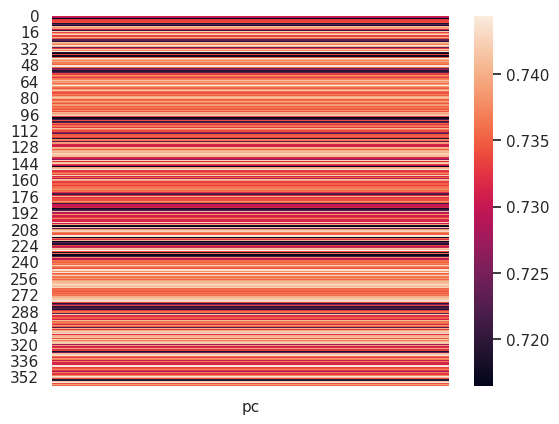

In [25]:
array = np.array(sub_graphs[0])
network_array = np.array(wm_networks.Subtype)


participation_coefs = participation_coef(array, network_array, degree='undirected')

pc_df = pd.concat([pd.DataFrame(network_array), pd.DataFrame(participation_coefs)], axis=1)
pc_df.columns = ['Subtype', 'pc']

sns.heatmap(pc_df.iloc[:, 1:])

In [26]:
sub_graph_effs =[]
for i in combined_all.SubID.unique():
    for j in ['maintain', 'replace', 'suppress', 'clear']:
        for k, l in zip(list(range(1,5)), ['vn', 'smn', 'fpcn', 'dmn']):
            sub_eff = combined_all.query('SubID == @i').query('Subtype == @k')
            sub_graph_effs.append(compute_network_metrics(sub_eff, j, l, i))
            
sub_graph_effs_df = pd.concat(sub_graph_effs).reset_index(drop=True) 
sub_graph_effs_df['SubID'] = sub_graph_effs_df.SubID.astype(int)

# Define a custom aggregation function that ignores NAs
# This function takes the first non-NA value it finds across the rows
def first_non_na(series):
    return series.dropna().iloc[0] if not series.dropna().empty else np.nan

# Group by 'SubID' and apply the custom aggregation function to each column
sub_graph_effs_df = sub_graph_effs_df.groupby('SubID', as_index=False).agg(first_non_na)

In [27]:
z_data = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/analysis/ClearMem_Z_Average.csv')
z_data = z_data[['SubID', 'z_ave', 'PSWQ_total', 'WBSI_total', 'RRS_total', 'RRS_depression', 'RRS_brooding', 'RRS_reflection']]
z_data = z_data.dropna()

matched_subid = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/subj/matched_subid.csv')
matched_subid.columns = ['sub', 'SubID']

In [28]:
sub_graph_effs_df = (pd.merge(matched_subid, sub_graph_effs_df, on = 'SubID')
                     .drop('SubID', axis=1).rename({'sub':'SubID'}, axis=1))

sub_graph_effs_z = pd.merge(z_data, sub_graph_effs_df, on ='SubID')

In [29]:
sub_graph_effs_df.to_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/dispersion_data/derosa_task_network_eigcent.csv', index=False)

In [30]:
#filter(regex='^(?!.*(cent)).*$')

Starting Permutations


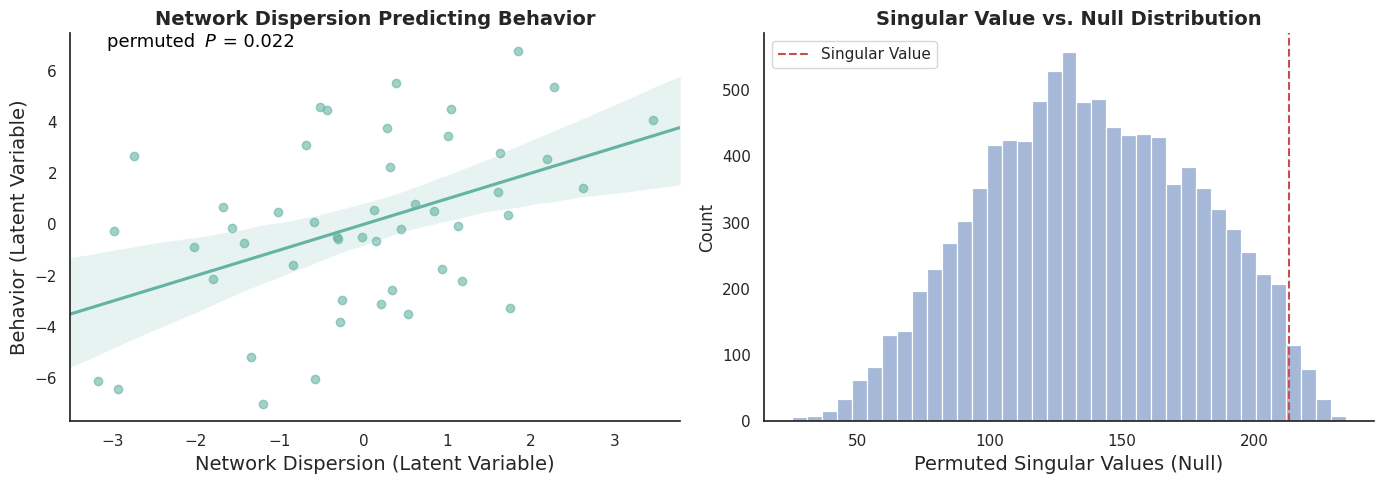

Starting Permutations


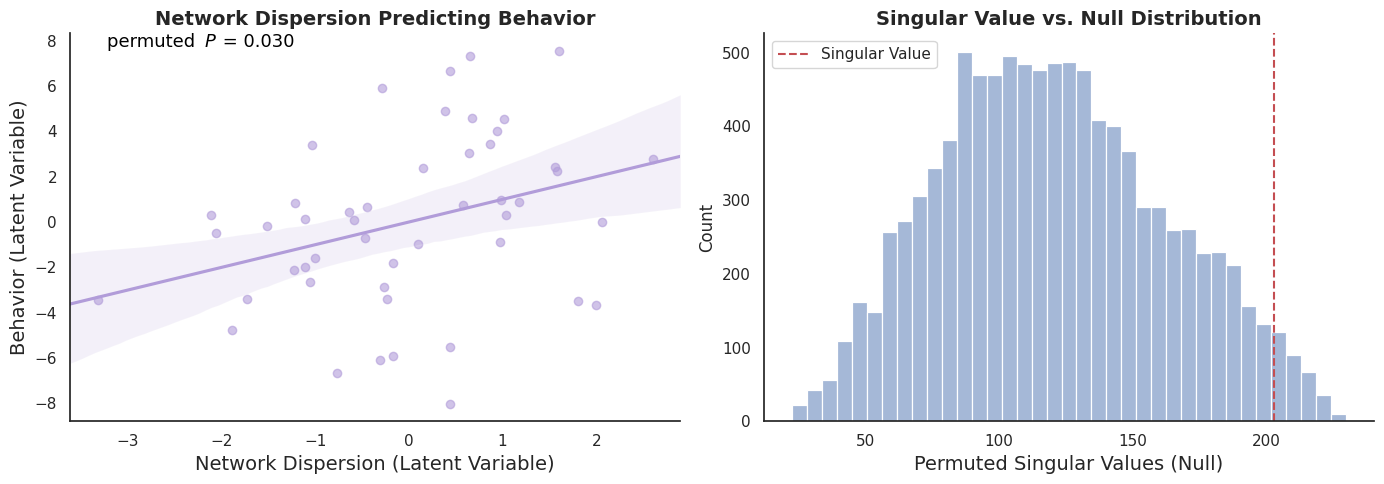

In [31]:
targets = [['RRS_total', 'PSWQ_total', 'WBSI_total'], ['z_ave']]
colors = ['#64b3a3', '#b19cd9']

networks = ['vn', 'smn', 'fpcn', 'dmn']
names = ['rrs_pws_wbsi_neteiggcent', 'z_ave_neteiggcent']

for i,j,k in zip(targets, colors, names):
    p_value, x_score, y_score, permuted_singular_values, singular_value = pls(sub_graph_effs_z, i, networks, j, k)

In [32]:
sub_net_disp = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/dispersion_data/derosa_task_network_dispersion.csv')
sub_net_disp_effs = pd.merge(sub_graph_effs_df, sub_net_disp, on='SubID')
sub_net_disp_effs_z = pd.merge(z_data, sub_net_disp_effs, on ='SubID')

Starting Permutations


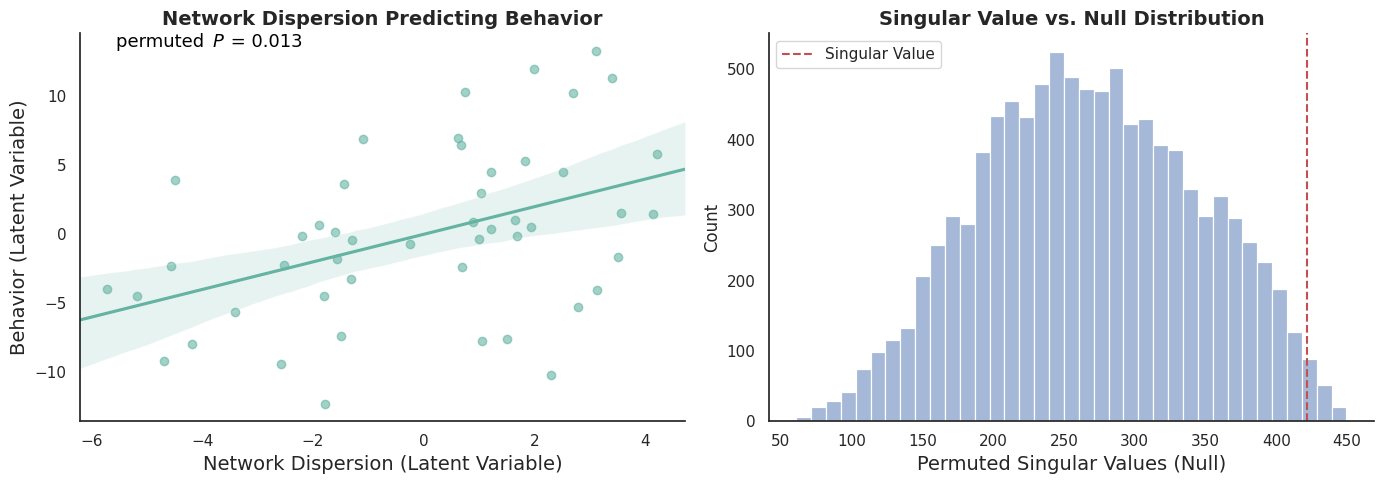

Starting Permutations


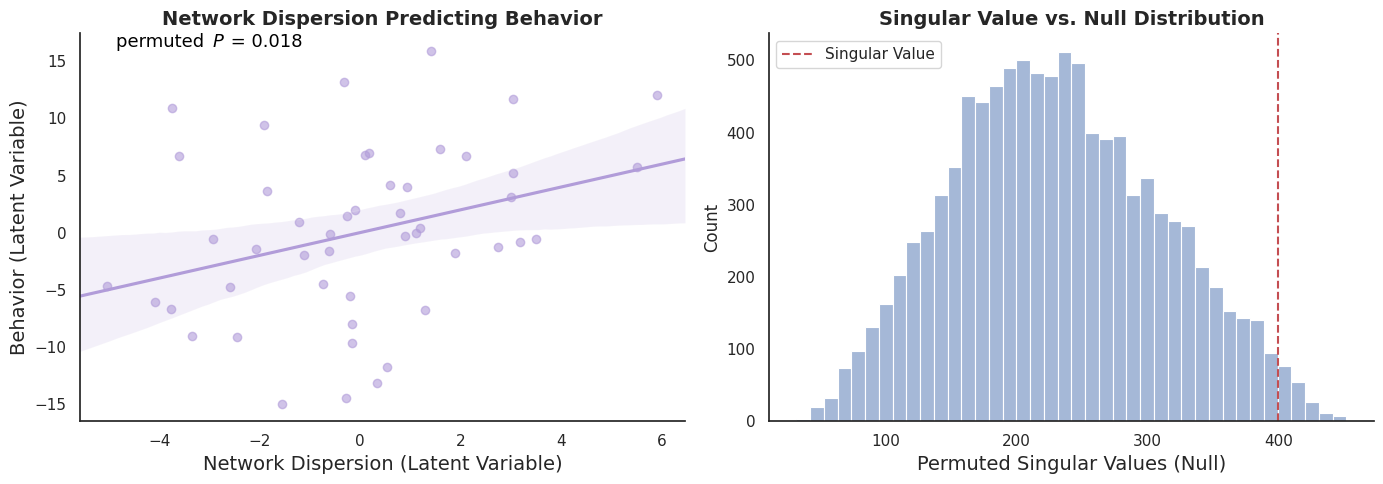

In [33]:
targets = [['RRS_total', 'PSWQ_total', 'WBSI_total'], ['z_ave']]
colors = ['#64b3a3', '#b19cd9']

networks = ['vn', 'smn', 'fpcn', 'dmn']
names = ['rrs_pws_wbsi_neteiggcentdisp', 'z_ave_neteiggcentdisp']

for i,j,k in zip(targets, colors, names):
    p_value, x_score, y_score, permuted_singular_values, singular_value = pls(sub_net_disp_effs_z, i, networks, j, k)

In [34]:
sub_net_disp_effs_z

,SubID,z_ave,PSWQ_total,WBSI_total,RRS_total,RRS_depression,RRS_brooding,RRS_reflection,maintain_vn_eigenvector_centrality,maintain_smn_eigenvector_centrality,...,replace_fpcn_dispersion_md,replace_dmn_dispersion_md,suppress_vn_dispersion_md,suppress_smn_dispersion_md,suppress_fpcn_dispersion_md,suppress_dmn_dispersion_md,clear_vn_dispersion_md,clear_smn_dispersion_md,clear_fpcn_dispersion_md,clear_dmn_dispersion_md
0,1,0.699836,51.0,63,66.0,43.0,11.0,12.0,9.403177,7.831016,...,144.998563,132.492432,142.491011,100.890915,145.463102,128.025370,139.060434,96.412910,139.511307,131.897360
1,4,-0.607031,40.0,48,34.0,18.0,9.0,7.0,9.549038,7.709220,...,140.851280,149.262222,147.277354,93.934106,143.925131,147.914273,140.762980,91.492325,145.559176,150.390650
2,5,1.587756,56.0,72,57.0,28.0,17.0,12.0,9.269134,7.867148,...,142.755313,141.198467,135.248691,102.228314,141.225793,137.475002,142.367489,104.094554,149.079019,138.450994
3,6,-0.490879,42.0,53,31.0,16.0,6.0,9.0,9.534907,7.712831,...,149.749336,146.474797,149.965808,97.001516,145.438701,149.958052,144.321637,91.900779,150.690369,154.739430
4,8,-1.359658,35.0,30,44.0,29.0,6.0,9.0,9.477547,7.808209,...,152.238207,150.462097,148.484612,99.227168,151.191657,147.874609,139.137539,95.280198,150.055159,147.128844
5,11,-0.613912,47.0,45,32.0,18.0,8.0,6.0,9.456953,7.795057,...,158.741196,151.560240,150.493832,97.923449,153.555574,140.600785,140.097504,94.727497,146.733389,158.471451
6,12,0.043399,55.0,45,42.0,23.0,13.0,6.0,9.587198,7.787490,...,151.559166,158.470169,150.814861,99.778725,152.498694,151.201136,151.464136,100.983437,157.220799,159.495097
7,13,0.082888,36.0,58,51.0,28.0,14.0,9.0,9.435740,7.892536,...,155.309960,153.018455,140.459738,100.440431,155.237533,149.349552,136.055099,96.003538,158.112882,147.100955
8,15,0.708171,47.0,62,50.0,25.0,15.0,10.0,9.337184,7.782587,...,150.893743,145.514795,137.154936,98.979874,148.332759,144.535273,130.768530,98.505801,148.331804,139.243478
9,17,0.551177,49.0,57,50.0,26.0,13.0,11.0,9.308930,7.819681,...,155.522582,152.589218,154.786462,98.831291,154.550523,153.352668,140.340369,93.913619,146.791978,149.392496
